In [2]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from torch import nn
from DDUN.SUNET.unet import Unet
from DDUN.SUNET.sddpm import MarkovDDPM
from DDUN.SUNET.embedding import SinsuoidalPostionalEmbedding
from DDUN.SUNET.utils import *
from tqdm.notebook import tqdm
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Markovddpm.load_state_dict(torch.load("models/best_ddpm_1000T.pt"))
# optimizer.load_state_dict(torch.load("models/optimizer.pt"))

In [4]:
# * Initialization
N_STEPS = 1000
BATCH_SIZE = 32  # 1024
TIME_EMB_DIM = 100
START = 0.0001
END = 0.02
lr = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"

# * Data
transform_data = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: (x - 0.5) * 2.0)]
)

reverse_transform = transforms.Compose(
    [
        transforms.Lambda(lambda t: (t + 1) / 2),
        # transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.0),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ]
)

loader = DataLoader(
    datasets.FashionMNIST("data", train=True, download=True, transform=transform_data),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [5]:
model = Unet(N_STEPS, TIME_EMB_DIM, DEVICE).to(DEVICE)
diffuse = MarkovDDPM(N_STEPS, START, END, 1, 28, DEVICE)
optimizer = Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()
pbar = tqdm(loader)
EPOCHS = 20
BEST_LOSS = float("inf")

  0%|          | 0/1875 [00:00<?, ?it/s]

In [6]:
model.load_state_dict(torch.load("models\SDDPM_model.pth"))
# optimizer.load_state_dict(torch.load("models/optimizer.pt"))

<All keys matched successfully>

In [35]:
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for i , (images, _) in enumerate(tqdm(loader)):
        images = images.to(DEVICE)
        #t = torch.arange(images.shape[0]).to(DEVICE)
        t = torch.randint(0, N_STEPS, (images.shape[0],), device=DEVICE).long()
        
        x_t, real_noise = diffuse.noise_images(images, t)
        predicted_noise = model(x_t, t)
        
        loss = mse(predicted_noise, real_noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pbar.set_postfix(MSE = loss.item())
        epoch_loss += loss.item()
        
    #* avg loss per epoch
    epoch_loss /= len(loader)
    
    
    if epoch_loss < BEST_LOSS:
        BEST_LOSS = epoch_loss
        torch.save(model.state_dict(), "models/SDDPM.pth")
        print("+++++++++++++++++++++++++++++++++++++++")
        print(f"at epoch {epoch} - loss improved to {BEST_LOSS:.6f}")
        print("+++++++++++++++++++++++++++++++++++++++")
    else: 
        print(f"Epoch {epoch} loss: {epoch_loss:.6f}")

  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 0 - loss improved to 0.1517772735675176
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 1 - loss improved to 0.07394484036266803
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 2 - loss improved to 0.06474124915500482
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 3 - loss improved to 0.06047440485060215
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 4 - loss improved to 0.05797066748539607
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 5 - loss improved to 0.0558117698987325
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 6 - loss improved to 0.054979371627171834
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 7 - loss improved to 0.05296896622230609
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 8 - loss improved to 0.05233162197073301
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 9 - loss improved to 0.051630611321330074
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 10 - loss improved to 0.05076278897970915
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 11 loss: 0.05079969602872928


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 12 - loss improved to 0.04936801162759463
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 13 loss: 0.04967908050715923


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 14 loss: 0.04970144815891981


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 15 - loss improved to 0.04847782321174939
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 16 - loss improved to 0.04774540880272786
+++++++++++++++++++++++++++++++++++++++


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 17 loss: 0.0483086474314332


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 18 loss: 0.047800212781131265


  0%|          | 0/1875 [00:00<?, ?it/s]

+++++++++++++++++++++++++++++++++++++++
at epoch 19 - loss improved to 0.047036067663133146
+++++++++++++++++++++++++++++++++++++++


In [7]:
gen, gen_hit = diffuse.generate(model, (16, 1, 28, 28), save_gen_hist=True)


gif with 92 frames saved


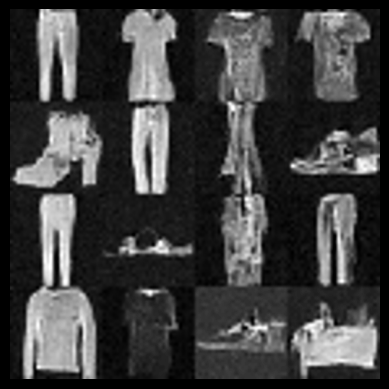

In [58]:
def save_gen_into_gif(self=None, gen_hist=None, gif_name=None):
    frames = []
    for idx, tensor in enumerate(gen_hist[-2*int(len(gen_hist)/3):]):
        if idx % 9 == 0:
            normalized = tensor.clone()
            
            for i in range(len(normalized)):
                normalized[i] -= torch.min(normalized[i])
                normalized[i] *= 255 / torch.max(normalized[i])
                
            #* resahimg to a square image
            frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(tensor.shape[0]** 0.5))
            frame = frame.cpu().numpy().astype(np.uint8)
            frame = np.squeeze(frame, axis=2)
            #* converting to PIL image
            frame = Image.fromarray(frame)
            frame = frame.resize((512, 512))
            frame = np.array(frame)
            frames.append(frame)
    for i in range(18):
        frames.append(frames[-1])
    
    if gif_name is None:
        gif_name = "SDDPM_results"
    imageio.mimsave(f'{gif_name}.gif', frames, format = 'GIF-PIL', fps =  100000 ) #type: ignore
    print(f'gif with {len(frames)} frames saved')
    plt.imshow(frames[-1], cmap='gray')
    plt.axis('off')
save_gen_into_gif(gen_hist=gen_hit)